# Filtering and Resampling

To include:
- [ ] Different filter types
- [ ] Filter slope and aliasing
- [ ] Causal and acausal
- [ ] How filters are represented (poles and zeros)
- [ ] Plotting various filter windows and their effect on data (both time and freq domain)
- [ ] Resampling - sinc as well as fourier - need to prefilter

In [1]:
# Set up notebook
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from obspy import read
from obspy.clients.fdsn import Client
from scipy import signal, fftpack
plt.style.use('ggplot') # Makes plots work well with dark theme

def filter_and_plot(data, dt, filt, zerophase=False):
    """
    Filter data using a simple filter and plot the data, the transfer 
    function and the filtered data. Plots will be in both time and
    frequency domain.
    
    :type data: `numpy.ndarray`
    :param data: Data to be filtered
    :type dt: float
    :param dt: Sample-interval (assumed to be in seconds).
    :type filt: `numpy.ndarray`
    :param filt: Frequency-domain representation of filter.
    """  
    N = len(data)
    filt_time = fftpack.ifft(filt)  # Generate a time-domain representation of the filter
    x_time = np.arange(0, N * dt, dt)
    
    fft_len = fftpack.next_fast_len(N)  # Find the next fast length for the FFT
    data_freq = fftpack.fft(data, n=fft_len)
    filtered_freq = data_freq * filt  # Filtering is multiplication in frequency domain
    filtered = fftpack.ifft(filtered_freq)
    if zerophase:
        # Do compute a zerophase filter - time-reverse the data and refilter
        data_freq_reversed = fftpack.fft(filtered[::-1], n=fft_len)
        filtered_freq = data_freq_reversed * filt
        filtered = fftpack.ifft(filtered_freq)[::-1]
    
    x_freq = np.linspace(0.0, 1.0 / (2. * dt), int(N / 2))
    
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
    
    axes[0][0].plot(x_time, data)
    axes[0][0].set_title("Input data")
    axes[0][1].plot(np.arange(0, len(filt_time) * dt, dt), np.real(filt_time))
    axes[0][1].set_title("Filter")
    axes[0][2].plot(x_time, np.real(filtered))
    axes[0][2].set_title("Filtered")
    
    axes[1][0].semilogx(x_freq, 2./N * np.abs(data_freq[:N//2]))    
    axes[1][1].semilogx(x_freq, 2./N * np.abs(filt[:N//2]))
    axes[1][2].semilogx(x_freq, 2./N * np.abs(filtered_freq[:N//2]))
    
    for ax in axes[0]:
        ax.set_xlabel("Time (s)")
        ax.autoscale(enable=True, axis='both', tight=True)
    for ax in axes[1]:
        ax.set_xlabel("Frequency (Hz)")
        ax.autoscale(enable=True, axis='both', tight=True)

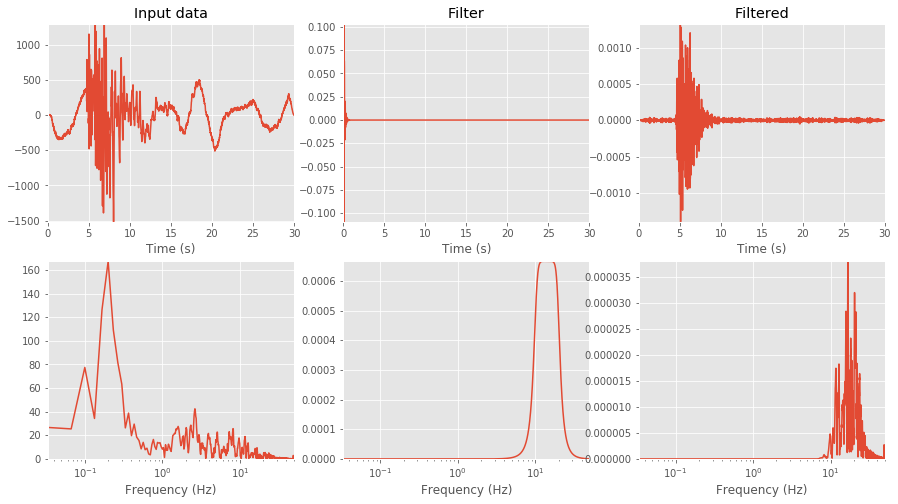

In [2]:
# Pass-band for bandpass filter
lowpass, highpass = (5., 10.)

tr = read()[0]
tr = tr.detrend()  # Data must be de-trended before filtering
nyquist = .5 * tr.stats.sampling_rate
# Check that highpass is usefully less than the nyquist
if highpass > (nyquist * .98):
    raise NotImplementedError(
        "Highpass {0} is higher than Nyquist {1}.".format(
            highpass, nyquist))
fft_len = fftpack.next_fast_len(tr.stats.npts)

# N is the "order" of the filter, Wn is the filter window.
b, a = signal.iirfilter(
    N=4, Wn=[lowpass, highpass], btype='band', analog=False, ftype='butter',
    output='ba', fs=tr.stats.sampling_rate)
x_freq, filt = signal.freqz(b, a, worN=fft_len, fs=tr.stats.sampling_rate)

filter_and_plot(tr.data, tr.stats.delta, filt=filt, zerophase=True)